# **Pesiapan Data**

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests

# --- Data teknikal ---
# Define the ticker of TSLA
ticker = 'TSLA'
start_date = '2018-11-15'  # not the start date, this is to make sure technical calculation not null

# Define the timeframe
trim_date = '2019-11-15'   # starting date
end_date = '2024-11-15'    # last data would be 2024-11-14

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

print(" ")
print(f"Jumlah data dengan frekuensi harian saham {ticker} periode {trim_date} sampai {end_date}")

# Clean columns to remove the MultiIndex second level
stock_data.columns = stock_data.columns.get_level_values(0)

# -------------------------------------------------
# MENANGANI NILAI YANG HILANG (MISSING VALUES)
# -------------------------------------------------

# Menghitung jumlah missing values per kolom sebelum interpolasi
missing_values_before = stock_data.isnull().sum()
print(f"Missing values sebelum interpolasi:\n{missing_values_before}")

# Menggunakan interpolasi linier untuk mengisi missing values
stock_data.interpolate(method='linear', inplace=True)

# Menghapus baris yang masih memiliki missing values setelah interpolasi (jika ada)
stock_data.dropna(inplace=True)

# Menghitung jumlah missing values per kolom setelah interpolasi
missing_values_after = stock_data.isnull().sum()
print(f"Missing values setelah interpolasi:\n{missing_values_after}")

# -------------------------------------------------
# DETEKSI DAN HAPUS OUTLIER (ANOMALI) PADA 'CLOSE'
# -------------------------------------------------

# a) Metode Z-Score
stock_data['z_score'] = (
    (stock_data['Close'] - stock_data['Close'].mean())
    / stock_data['Close'].std()
)
threshold_z = 3  # batas umum: 3 SD dari mean
stock_data['z_outlier'] = (np.abs(stock_data['z_score']) > threshold_z)

# b) Metode IQR
Q1 = stock_data['Close'].quantile(0.25)
Q3 = stock_data['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stock_data['iqr_outlier'] = ~stock_data['Close'].between(lower_bound, upper_bound)

# c) Gabungkan keduanya: hanya ambil data yang BUKAN outlier
stock_data = stock_data[
    (stock_data['z_outlier'] == False)
    & (stock_data['iqr_outlier'] == False)
]

# d) Hapus kolom bantu outlier
stock_data.drop(['z_score','z_outlier','iqr_outlier'], axis=1, inplace=True)

# -------------------------------------------------
# Lanjutkan dengan perhitungan indikator teknikal
# -------------------------------------------------

# ATR (Average True Range) - contoh dengan rolling 14 hari
stock_data['ATR'] = (stock_data['High'] - stock_data['Low']).rolling(window=14).mean()

# Bollinger Bands Width (BB_Width) - contoh rolling 20 hari
stock_data['BB_Width'] = 2 * stock_data['Close'].rolling(window=20).std()

# RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data['RSI'] = compute_rsi(stock_data['Close'])

# MACD (Moving Average Convergence Divergence)
ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26

# ---------------------------------------
# Penambahan breakout_label
# ---------------------------------------
rolling_window = 10
stock_data[f'Highest_Close_{rolling_window}'] = (
    stock_data['Close'].shift(1).rolling(window=rolling_window).max()
)
stock_data[f'Lowest_Close_{rolling_window}'] = (
    stock_data['Close'].shift(1).rolling(window=rolling_window).min()
)
stock_data['Consolidation'] = (
    stock_data[f'Lowest_Close_{rolling_window}'] > 0.89 * stock_data[f'Highest_Close_{rolling_window}']
).astype(int)

def determine_breakout(row):
    if row['Consolidation'] == 1:
        if row['Close'] > row[f'Highest_Close_{rolling_window}']:
            return 1  # Breakout di atas
        elif row['Close'] < row[f'Lowest_Close_{rolling_window}']:
            return 0  # Breakout di bawah
    return 0  # Tidak ada breakout atau tidak dalam konsolidasi

stock_data['breakout_label'] = stock_data.apply(determine_breakout, axis=1)

print(" ")
consolidation_count = stock_data['Consolidation'].sum()
print(f"Jumlah hari dalam konsolidasi: {consolidation_count}")
breakout_up_count = (stock_data['breakout_label'] == 1).sum()
print(f"Jumlah breakout ke atas: {breakout_up_count}")

# Drop intermediate columns if not needed
stock_data.drop(
    ['Adj Close', f'Highest_Close_{rolling_window}',
     f'Lowest_Close_{rolling_window}', 'Consolidation'],
    axis=1,
    inplace=True,
    errors='ignore'  # untuk jaga-jaga jika kolom sudah tidak ada
)

# Trim data starting from '2019-11-15'
stock_data = stock_data[stock_data.index >= trim_date]

# ---------------------------------------
# Simpan ke CSV / XLSX
# ---------------------------------------
try:
    stock_data.to_csv(f'{ticker}_technical_stock_data.csv')
    # Opsional: Simpan juga ke XLSX
    is_save_xlsx = True
    if is_save_xlsx:
        # Pastikan indeks datetime bebas dari zona waktu
        if stock_data.index.tz is not None:
            stock_data.index = stock_data.index.tz_localize(None)
        if 'Date' in stock_data.columns:
            stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)
        stock_data.to_excel(f'{ticker}_technical_stock_data.xlsx')

except Exception as e:
    print("GAGAL SAVE KARENA FILE MASIH TERBUKA")
    print(e)

print("Proses selesai. File CSV/XLSX berhasil disimpan (kecuali muncul pesan error).")


[*********************100%***********************]  1 of 1 completed


 
Jumlah data dengan frekuensi harian saham TSLA periode 2019-11-15 sampai 2024-11-15
Missing values sebelum interpolasi:
Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64
Missing values setelah interpolasi:
Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64
 
Jumlah hari dalam konsolidasi: 687
Jumlah breakout ke atas: 149
Proses selesai. File CSV/XLSX berhasil disimpan (kecuali muncul pesan error).


In [29]:
# Combine with fundamental data

# Load fundamental data
fundamental_data = pd.read_csv('TSLA_fundamental_data.csv')
fundamental_data['Date'] = pd.to_datetime(fundamental_data['Date'])

# Tambahkan kolom YearMonth asli
fundamental_data['YearMonth'] = fundamental_data['Date'].dt.to_period('M')

# Ekstraksi data fundamental ke tiga bulan berturut-turut
expanded_rows = []
for _, row in fundamental_data.iterrows():
    # Ambil YearMonth asli
    base_yearmonth = row['YearMonth']
    # Tambahkan tiga bulan berturut-turut
    for offset in range(3):
        new_yearmonth = (base_yearmonth + offset)
        expanded_rows.append({
            'YearMonth': new_yearmonth,
            'eps': row['eps'],
            'netIncome': row['netIncome']
        })

# Buat DataFrame baru dengan data yang diperluas
expanded_fundamental_data = pd.DataFrame(expanded_rows)

# Lakukan merge dengan stock_data seperti sebelumnya
stock_data['YearMonth'] = stock_data.index.to_period('M')
merged_fundamental_data = pd.merge(stock_data, expanded_fundamental_data, on='YearMonth', how='left')

# Hapus kolom tambahan jika tidak diperlukan
merged_fundamental_data.drop(columns=['YearMonth'], inplace=True)
stock_data.drop(columns=['YearMonth'], inplace=True)

# Kembalikan indeks ke 'Date' dari data teknikal
merged_fundamental_data.set_index(stock_data.index, inplace=True)

# Tambahkan kolom pct_eps dan pct_netIncome
# Persentase perubahan dibandingkan periode sebelumnya
merged_fundamental_data['pct_eps'] = merged_fundamental_data['eps'].pct_change() * 100
merged_fundamental_data['pct_eps'] = merged_fundamental_data['pct_eps'].fillna(0)

merged_fundamental_data['pct_netIncome'] = merged_fundamental_data['netIncome'].pct_change() * 100
merged_fundamental_data['pct_netIncome'] = merged_fundamental_data['pct_netIncome'].fillna(0)

# Simpan hasil ke stock_data
stock_data['eps'] = merged_fundamental_data['eps']
stock_data['netIncome'] = merged_fundamental_data['netIncome']
stock_data['pct_eps'] = merged_fundamental_data['pct_eps']
stock_data['pct_netIncome'] = merged_fundamental_data['pct_netIncome']

# Simpan hasil gabungan ke file CSV
try:
    merged_fundamental_data.to_csv(f'{ticker}_technical_fundamental_stock_data.csv', index=True)
    merged_fundamental_data.to_excel(f'{ticker}_technical_fundamental_stock_data.xlsx')
    print(f"File gabungan telah disimpan sebagai {ticker}_technical_fundamental_stock_data.csv")
except Exception as e:
    print(f"Gagal menyimpan file gabungan: {e}")

# Tampilkan hasil akhir
print("Hasil akhir penggabungan:")
print(merged_fundamental_data.head())


File gabungan telah disimpan sebagai TSLA_technical_fundamental_stock_data.csv
Hasil akhir penggabungan:
                Close       High        Low       Open     Volume       ATR  \
Date                                                                          
2019-11-15  23.478001  23.520000  23.224001  23.375999   72135000  0.580095   
2019-11-18  23.332666  23.543333  23.073334  23.528000   66006000  0.568190   
2019-11-19  23.968000  23.999332  23.186666  23.450001  115872000  0.584238   
2019-11-20  23.481333  24.080000  23.304667  24.000000  100876500  0.611047   
2019-11-21  23.655333  24.056000  23.600000  23.634001   91650000  0.611809   

            BB_Width        RSI      MACD  breakout_label   eps  netIncome  \
Date                                                                         
2019-11-15  4.113413  69.918554  1.581002               1  0.12  143000000   
2019-11-18  3.686674  82.415022  1.548284               0  0.12  143000000   
2019-11-19  3.187547  86.8398

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# --- Langkah 1: Siapkan Data ---

# Salin data awal sebelum drop
original_data = stock_data.copy()

# Buat label target (1 untuk naik, 0 untuk tidak naik)
# Target adalah harga "Close" 90 hari ke depan dibandingkan harga saat ini
original_data['Close_90d'] = original_data['Close'].shift(-90)
original_data['point'] = np.where(
    original_data['Close_90d'].isna(),
    np.nan,
    (original_data['Close_90d'] > original_data['Close']).astype(int)
)

# Data untuk training (hanya baris tanpa NaN pada target)
train_data = original_data.dropna(subset=['point'])

# Pilih fitur dan target untuk training
features = ['Close', 'High', 'Low', 'Open', 'Volume']
target = 'point'

X = train_data[features]
y = train_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Langkah 2: Train Random Forest Model ---
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Tampilkan hasil evaluasi
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")

# --- Langkah 3: Prediksi Semua Data ---
# Prediksi seluruh dataset (termasuk baris tanpa target)
X_full = original_data[features]
original_data['rf_pred_up_90d'] = model.predict(X_full)

# Drop unnecessary columns
original_data.drop(columns=['Close_90d', 'point'], inplace=True)

# Simpan hasil ke stock_data
stock_data['rf_pred_up_90d'] = original_data['rf_pred_up_90d']

# Simpan data ke file merged_random_forest_prediction_data
merged_random_forest_prediction_data = original_data.copy()

try:
    merged_random_forest_prediction_data.to_csv(f'{ticker}_random_forest_prediction_data.csv', index=True)
    merged_random_forest_prediction_data.to_excel(f'{ticker}_random_forest_prediction_data.xlsx')
    print(f"File prediksi telah disimpan sebagai {ticker}_random_forest_prediction_data.csv")
except Exception as e:
    print(f"Gagal menyimpan file prediksi: {e}")

# Tampilkan hasil akhir
print("Hasil akhir prediksi (dengan data lengkap):")
print(original_data.head())


Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85        97
         1.0       0.90      0.88      0.89       137

    accuracy                           0.87       234
   macro avg       0.87      0.87      0.87       234
weighted avg       0.87      0.87      0.87       234

Accuracy Score: 0.87
File prediksi telah disimpan sebagai TSLA_random_forest_prediction_data.csv
Hasil akhir prediksi (dengan data lengkap):
Price           Close       High        Low       Open     Volume       ATR  \
Date                                                                          
2019-11-15  23.478001  23.520000  23.224001  23.375999   72135000  0.580095   
2019-11-18  23.332666  23.543333  23.073334  23.528000   66006000  0.568190   
2019-11-19  23.968000  23.999332  23.186666  23.450001  115872000  0.584238   
2019-11-20  23.481333  24.080000  23.304667  24.000000  100876500  0.611047   
2019-11-21  23.655333  24.056000  2

# Implementasi SVM

C:\Users\gusti\AppData\Local\Temp\ipykernel_4788\50499189.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Breakout_Score'] = oc_svm.decision_function(scaled_features)  # Higher score = more normal
C:\Users\gusti\AppData\Local\Temp\ipykernel_4788\50499189.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Breakout_Flag'] = oc_svm.predict(scaled_features)  # 1 = normal, -1 = anomaly


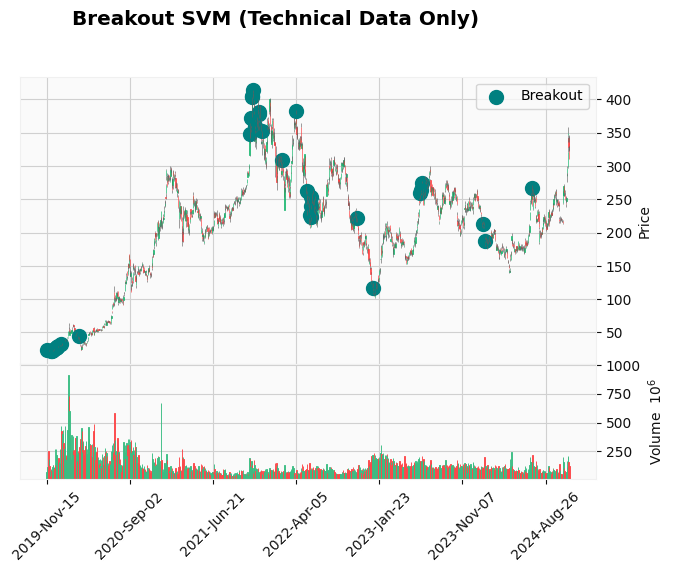

Accuracy: 0.89
Precision: 0.08
Recall: 0.03
F1-Score: 0.04


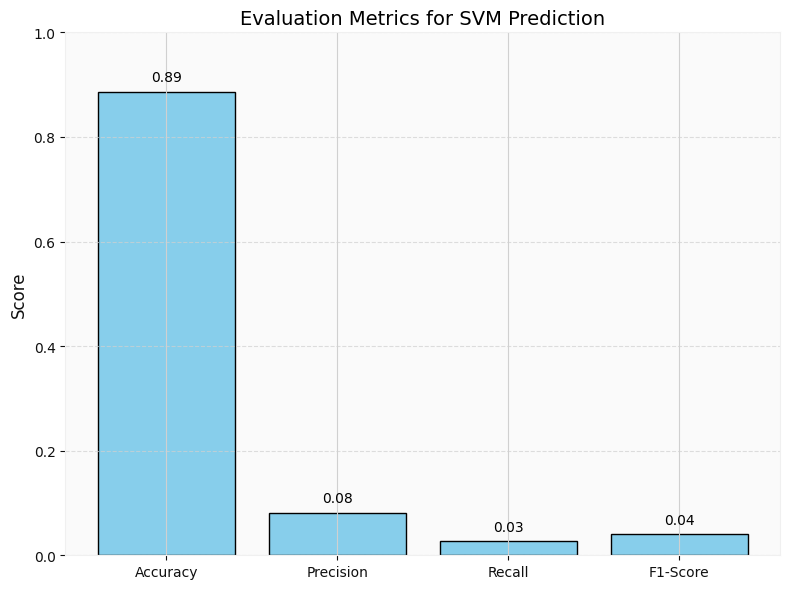

In [31]:
# Implementasi SVM dengan data teknikal

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import mplfinance as mpf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Drop NaNs from rolling calculations
features = stock_data[['ATR', 'BB_Width', 'RSI', 'MACD']]

# Scale features for SVM
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)  # Adjust gamma and nu as needed
oc_svm.fit(scaled_features)

# Predict breakout candidates
features['Breakout_Score'] = oc_svm.decision_function(scaled_features)  # Higher score = more normal
features['Breakout_Flag'] = oc_svm.predict(scaled_features)  # 1 = normal, -1 = anomaly

# Merge results with original stock data
stock_data = stock_data.iloc[-len(features):].copy()  # Align indices
stock_data['Breakout_Flag'] = features['Breakout_Flag'].values

# --- Filter for Upward Breakouts ---
# Define upward breakout conditions
stock_data['pred_up_breakout'] = np.where(
    (stock_data['Breakout_Flag'] == -1) &  # Detected as breakout by SVM
    (stock_data['Close'] > stock_data['Close'].shift(1)),  # Close price is higher than previous Close
    1,  # Upward breakout
    0   # Not an upward breakout
)

# Align upward breakout points for plotting
breakout_up_aligned = pd.Series(index=stock_data.index, dtype=float)
breakout_up_aligned[stock_data['pred_up_breakout'] == 1] = stock_data['High']

# Plot candlestick chart with breakout annotations
ohlc_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Define OHLC data

# Drop unnecessary columns
stock_data.drop(columns=['Breakout_Flag'], inplace=True)

apdict = [
    mpf.make_addplot(breakout_up_aligned, scatter=True, markersize=100, marker='o', color='teal', label='Breakout')
]

mpf.plot(
    ohlc_data,
    type='candle',
    volume=True,
    style='yahoo',
    addplot=apdict,
    warn_too_much_data=100000,
    title='Breakout SVM (Technical Data Only)',
    ylabel='Price'
)


# Evaluasi

# Extract true labels and predictions
y_true = stock_data['breakout_label']
y_pred = stock_data['pred_up_breakout']  # Predicted flags from SVM

# Ensure alignment
assert len(y_true) == len(y_pred), "Mismatch in lengths of true and predicted labels."

# Map SVM predictions (-1 -> 0 for no-breakout, 1 -> 1 for breakout)
y_pred = y_pred.replace({-1: 0, 1: 1})  # Adjust based on breakout logic

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

import matplotlib.pyplot as plt

# Metrics for the evaluation
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue', edgecolor='black')
plt.title('Evaluation Metrics for SVM Prediction', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the metric value
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()



C:\Users\gusti\AppData\Local\Temp\ipykernel_4788\3856283868.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Breakout_Score'] = oc_svm.decision_function(scaled_features)  # Higher score = more normal
C:\Users\gusti\AppData\Local\Temp\ipykernel_4788\3856283868.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Breakout_Flag'] = oc_svm.predict(scaled_features)  # 1 = normal, -1 = anomaly


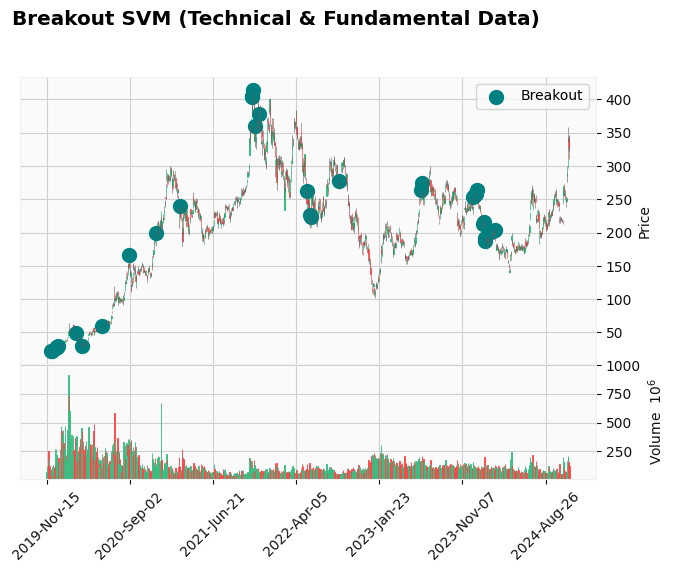

Accuracy: 0.89
Precision: 0.17
Recall: 0.05
F1-Score: 0.08


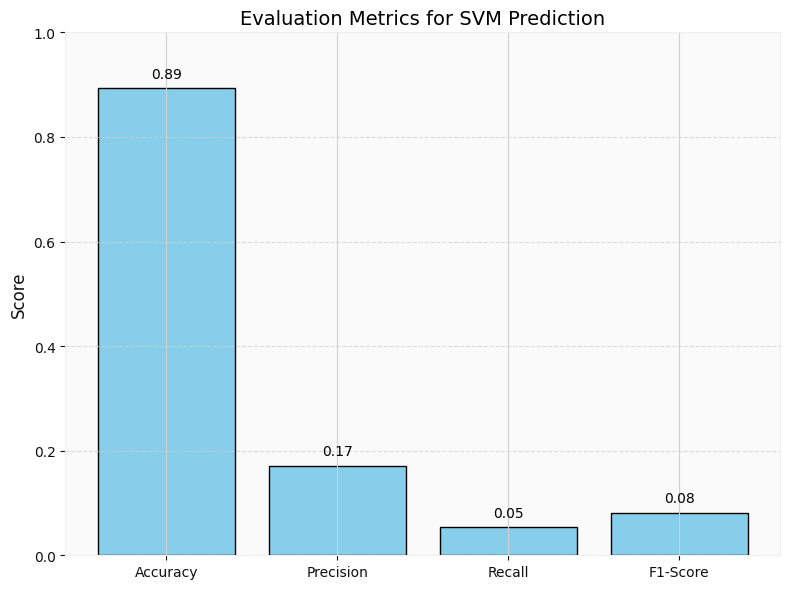

In [34]:
# Implementasi SVM dengan data teknikal dan fundamental

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import mplfinance as mpf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Drop NaNs from rolling calculations
features = stock_data[['ATR', 'BB_Width', 'RSI', 'MACD', 'netIncome', 'pct_netIncome']]

# Scale features for SVM
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)  # Adjust gamma and nu as needed
oc_svm.fit(scaled_features)

# Predict breakout candidates
features['Breakout_Score'] = oc_svm.decision_function(scaled_features)  # Higher score = more normal
features['Breakout_Flag'] = oc_svm.predict(scaled_features)  # 1 = normal, -1 = anomaly

# Merge results with original stock data
stock_data = stock_data.iloc[-len(features):].copy()  # Align indices
stock_data['Breakout_Flag'] = features['Breakout_Flag'].values

# --- Filter for Upward Breakouts ---
# Define upward breakout conditions
stock_data['pred_up_breakout'] = np.where(
    (stock_data['Breakout_Flag'] == -1) &  # Detected as breakout by SVM
    (stock_data['Close'] > stock_data['Close'].shift(1)),  # Close price is higher than previous Close
    1,  # Upward breakout
    0   # Not an upward breakout
)

# Align upward breakout points for plotting
breakout_up_aligned = pd.Series(index=stock_data.index, dtype=float)
breakout_up_aligned[stock_data['pred_up_breakout'] == 1] = stock_data['High']

# Plot candlestick chart with breakout annotations
ohlc_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Define OHLC data

# Drop unnecessary columns
stock_data.drop(columns=['Breakout_Flag'], inplace=True)

apdict = [
    mpf.make_addplot(breakout_up_aligned, scatter=True, markersize=100, marker='o', color='teal', label='Breakout')
]

mpf.plot(
    ohlc_data,
    type='candle',
    volume=True,
    style='yahoo',
    addplot=apdict,
    warn_too_much_data=100000,
    title='Breakout SVM (Technical & Fundamental Data)',
    ylabel='Price'
)

# Evaluasi

# Extract true labels and predictions
y_true = stock_data['breakout_label']
y_pred = stock_data['pred_up_breakout']  # Predicted flags from SVM

# Ensure alignment
assert len(y_true) == len(y_pred), "Mismatch in lengths of true and predicted labels."

# Map SVM predictions (-1 -> 0 for no-breakout, 1 -> 1 for breakout)
y_pred = y_pred.replace({-1: 0, 1: 1})  # Adjust based on breakout logic

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

import matplotlib.pyplot as plt

# Metrics for the evaluation
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue', edgecolor='black')
plt.title('Evaluation Metrics for SVM Prediction', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the metric value
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()



C:\Users\gusti\AppData\Local\Temp\ipykernel_4788\1058283320.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Breakout_Score'] = oc_svm.decision_function(scaled_features)  # Higher score = more normal
C:\Users\gusti\AppData\Local\Temp\ipykernel_4788\1058283320.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Breakout_Flag'] = oc_svm.predict(scaled_features)  # 1 = normal, -1 = anomaly


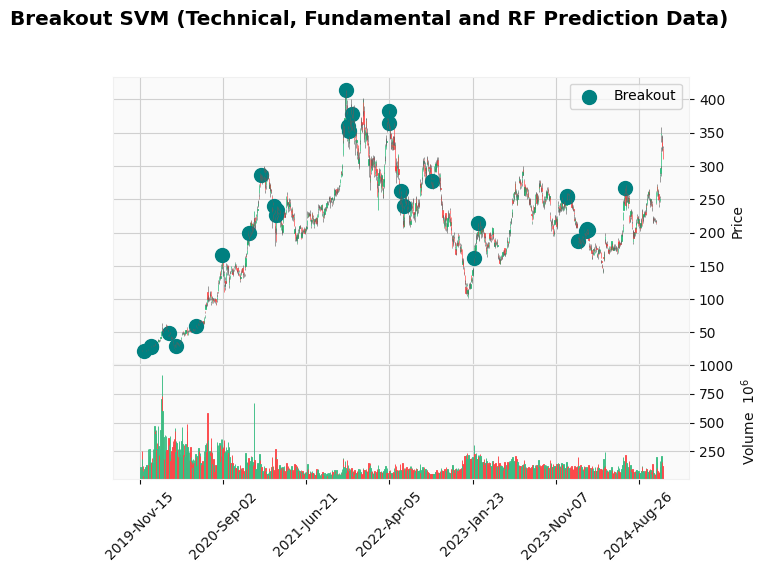

Accuracy: 0.89
Precision: 0.13
Recall: 0.04
F1-Score: 0.06


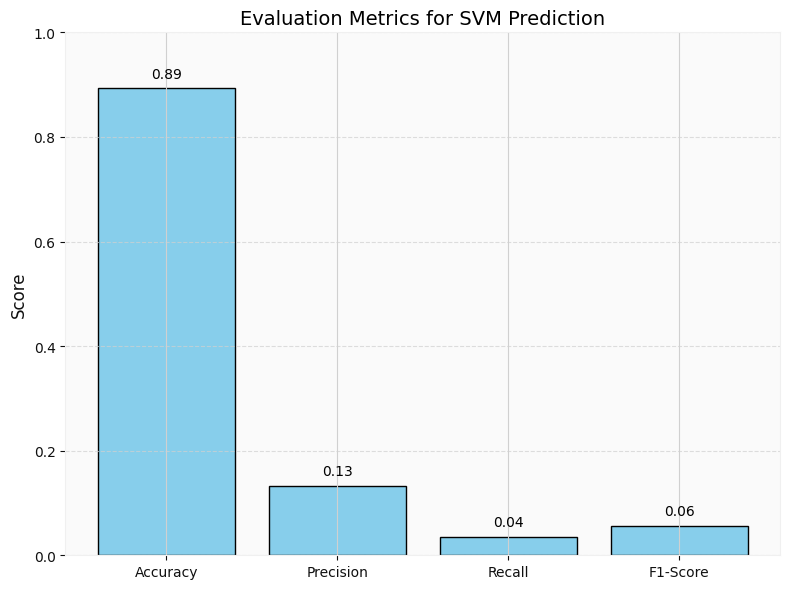

In [14]:
# Implementasi SVM dengan data teknikal, fundamental dan random forest prediction

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import mplfinance as mpf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Drop NaNs from rolling calculations
features = stock_data[['ATR', 'BB_Width', 'RSI', 'MACD', 'eps', 'netIncome', 'pct_eps', 'pct_netIncome', 'rf_pred_up_90d']]

# Scale features for SVM
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)  # Adjust gamma and nu as needed
oc_svm.fit(scaled_features)

# Predict breakout candidates
features['Breakout_Score'] = oc_svm.decision_function(scaled_features)  # Higher score = more normal
features['Breakout_Flag'] = oc_svm.predict(scaled_features)  # 1 = normal, -1 = anomaly

# Merge results with original stock data
stock_data = stock_data.iloc[-len(features):].copy()  # Align indices
stock_data['Breakout_Flag'] = features['Breakout_Flag'].values

# --- Filter for Upward Breakouts ---
# Define upward breakout conditions
stock_data['pred_up_breakout'] = np.where(
    (stock_data['Breakout_Flag'] == -1) &  # Detected as breakout by SVM
    (stock_data['Close'] > stock_data['Close'].shift(1)),  # Close price is higher than previous Close
    1,  # Upward breakout
    0   # Not an upward breakout
)

# Align upward breakout points for plotting
breakout_up_aligned = pd.Series(index=stock_data.index, dtype=float)
breakout_up_aligned[stock_data['pred_up_breakout'] == 1] = stock_data['High']

# Plot candlestick chart with breakout annotations
ohlc_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Define OHLC data

# Drop unnecessary columns
stock_data.drop(columns=['Breakout_Flag'], inplace=True)

apdict = [
    mpf.make_addplot(breakout_up_aligned, scatter=True, markersize=100, marker='o', color='teal', label='Breakout')
]

mpf.plot(
    ohlc_data,
    type='candle',
    volume=True,
    style='yahoo',
    addplot=apdict,
    warn_too_much_data=100000,
    title='Breakout SVM (Technical, Fundamental and RF Prediction Data)',
    ylabel='Price'
)

# Evaluasi

# Extract true labels and predictions
y_true = stock_data['breakout_label']
y_pred = stock_data['pred_up_breakout']  # Predicted flags from SVM

# Ensure alignment
assert len(y_true) == len(y_pred), "Mismatch in lengths of true and predicted labels."

# Map SVM predictions (-1 -> 0 for no-breakout, 1 -> 1 for breakout)
y_pred = y_pred.replace({-1: 0, 1: 1})  # Adjust based on breakout logic

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

import matplotlib.pyplot as plt

# Metrics for the evaluation
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue', edgecolor='black')
plt.title('Evaluation Metrics for SVM Prediction', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the metric value
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()



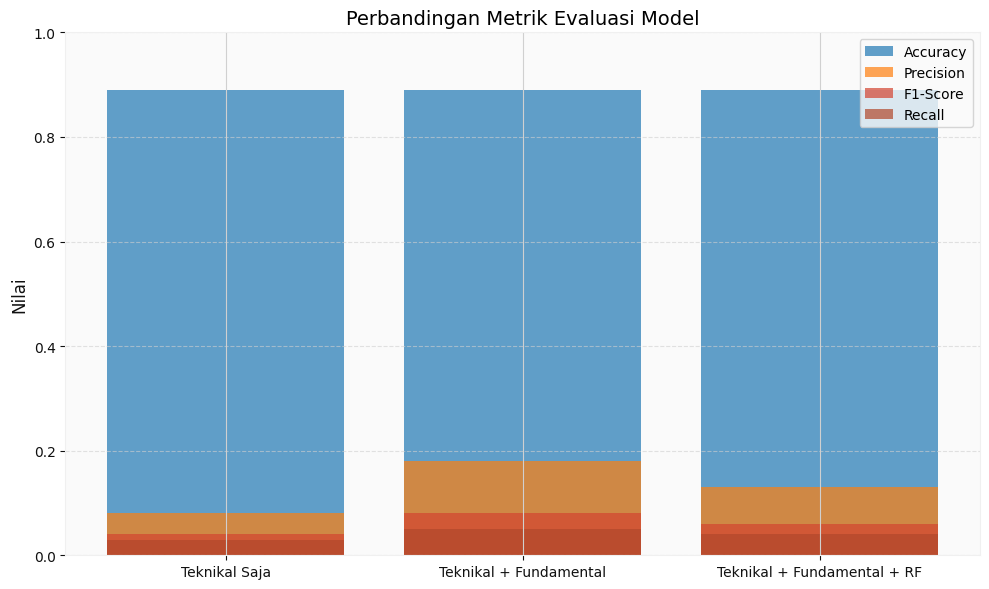

In [26]:
# Visualisasi Perbandingan Metrik
import matplotlib.pyplot as plt

# Data untuk visualisasi
models = ['Teknikal Saja', 'Teknikal + Fundamental', 'Teknikal + Fundamental + RF']
accuracy = [0.89, 0.89, 0.89]
precision = [0.08, 0.18, 0.13]
recall = [0.03, 0.05, 0.04]
f1_score = [0.04, 0.08, 0.06]

# Plot metrik evaluasi
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, label='Accuracy', alpha=0.7)
plt.bar(models, precision, label='Precision', alpha=0.7)
plt.bar(models, f1_score, label='F1-Score', color="#d34430", alpha=0.7)
plt.bar(models, recall, label='Recall', color="#b1482b", alpha=0.7)
plt.title('Perbandingan Metrik Evaluasi Model', fontsize=14)
plt.ylabel('Nilai', fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Deprecated

In [ ]:
# VERSION 2

import yfinance as yf
import pandas as pd
import requests

# --- Data teknikal ---
# Define the ticker of TSLA
ticker = 'TSLA'

# Define the timeframe
start_date = '2018-11-15'
end_date = '2024-11-15'

# Define the trimming date
trim_date = '2019-11-15'

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate Moving Averages
stock_data['MA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()

# Calculate ADR for 10 days
Daily_Range = stock_data['High'] - stock_data['Low']
stock_data['ADR'] = Daily_Range.rolling(window=10).mean()

# Clean columns to remove the MultiIndex second level
stock_data.columns = stock_data.columns.get_level_values(0)

# --- Penambahan breakout_label --- #
rolling_window = 5  # Window untuk konsolidasi dan breakout

# Calculate highest and lowest closing prices
stock_data[f'Highest_Close_{rolling_window}'] = (
    stock_data['Close'].shift(1).rolling(window=rolling_window).max()
)
stock_data[f'Lowest_Close_{rolling_window}'] = (
    stock_data['Close'].shift(1).rolling(window=rolling_window).min()
)

# Calculate Average True Range (ATR)
stock_data['ATR'] = (
    (stock_data['High'] - stock_data['Low']).rolling(window=rolling_window).mean()
)


# --- Penambahan indikator teknikal ---

# ATR (Average True Range)
stock_data['ATR'] = (stock_data['High'] - stock_data['Low']).rolling(window=14).mean()

# Bollinger Bands Width (BB_Width)
stock_data['BB_Width'] = 2 * stock_data['Close'].rolling(window=20).std()

# RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data['RSI'] = compute_rsi(stock_data['Close'])

# MACD (Moving Average Convergence Divergence)
ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26

# Calculate consolidation condition
stock_data['Consolidation'] = (
    (stock_data[f'Highest_Close_{rolling_window}'] - stock_data[f'Lowest_Close_{rolling_window}']) < 1.5 * stock_data['ATR']
).astype(int)

# Calculate Volume Average
stock_data['Volume_Avg'] = stock_data['Volume'].rolling(window=rolling_window).mean()

# Define Downtrend
stock_data['Downtrend'] = (stock_data['MA_20'] < stock_data['MA_50']).astype(int)

# Tambahkan kolom All-Time High (ATH)
stock_data['ATH'] = stock_data['Close'].cummax().shift(1)

# Determine breakout_label with confirmation
def determine_breakout(row):
    if row['Consolidation'] == 1:  # Only consider breakout if in consolidation
        if row['Close'] > row[f'Highest_Close_{rolling_window}'] + 1 * row['ATR'] and row['Volume'] > row['Volume_Avg'] and row['Close'] < row['ATH'] and row['Downtrend'] == 0:
            print(f"Breakout up detected at {row.name}: Close={row['Close']} > Highest_Close_{rolling_window}={row[f'Highest_Close_{rolling_window}']} + 1*ATR={row['ATR']}")
            return 1  # Breakout up
        elif row['Close'] < row[f'Lowest_Close_{rolling_window}'] - 1 * row['ATR'] and row['Volume'] > row['Volume_Avg']:
            return 0  # Breakout down
    return 0  # No breakout or no consolidation

stock_data['breakout_label'] = stock_data.apply(determine_breakout, axis=1)

# --- Statistik Breakout --- #
consolidation_count = stock_data['Consolidation'].sum()
breakout_up_count = (stock_data['breakout_label'] == 1).sum()
breakout_down_count = (stock_data['breakout_label'] == -1).sum()

print(f"\nJumlah hari dalam konsolidasi: {consolidation_count}")
print(f"Jumlah breakout ke atas: {breakout_up_count}")
print(f"Jumlah breakout ke bawah: {breakout_down_count}")

# Drop intermediate columns if not needed
# stock_data.drop(['Highest_Close_{rolling_window}', 'Lowest_Close_{rolling_window}', 'Consolidation'], axis=1, inplace=True)

# Trim data starting from '2019-11-15'
stock_data = stock_data[stock_data.index >= trim_date]

try:
  # save as csv
  stock_data.to_csv(f'{ticker}_stock_data.csv')

  # check columns
  # print(stock_data.columns)

  # save as xlsx
  is_save_xlsx = True
  if (is_save_xlsx):
    # Pastikan indeks datetime bebas dari zona waktu
    if stock_data.index.tz is not None:
        stock_data.index = stock_data.index.tz_localize(None)
    # Pastikan kolom 'Date' bebas dari zona waktu
    if 'Date' in stock_data.columns:
        stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)
    stock_data.to_excel(f'{ticker}_stock_data_human_readable.xlsx')
except(Exception):
  print("GAGAL SAVE KARENA FILE MASIH TERBUKA")

# gambar csv dengan candlestick dan berikan titik bentuk box untuk setiap breakout_label bernilai 1 dan -1 (1 = up box warna hijau, -1 = down box warna merah)




[*********************100%***********************]  1 of 1 completed


Breakout up detected at 2019-10-14 00:00:00+00:00: Close=17.130666732788086 > Highest_Close_5=16.525999069213867 + 1*ATR=0.5264007568359375
Breakout up detected at 2019-10-24 00:00:00+00:00: Close=19.978666305541992 > Highest_Close_5=17.46466636657715 + 1*ATR=0.6002666473388671
Breakout up detected at 2019-11-06 00:00:00+00:00: Close=21.77199935913086 > Highest_Close_5=21.1646671295166 + 1*ATR=0.5996002197265625
Breakout up detected at 2019-12-10 00:00:00+00:00: Close=23.256000518798828 > Highest_Close_5=22.635332107543945 + 1*ATR=0.49413299560546875
Breakout up detected at 2020-06-01 00:00:00+00:00: Close=59.87333297729492 > Highest_Close_5=55.66666793823242 + 1*ATR=2.138001251220703
Breakout up detected at 2020-12-30 00:00:00+00:00: Close=231.5933380126953 > Highest_Close_5=221.99667358398438 + 1*ATR=7.850668334960938
Breakout up detected at 2021-08-30 00:00:00+00:00: Close=243.6366729736328 > Highest_Close_5=237.30667114257812 + 1*ATR=4.966665649414063
Breakout up detected at 2021-0

No breakout down points found.


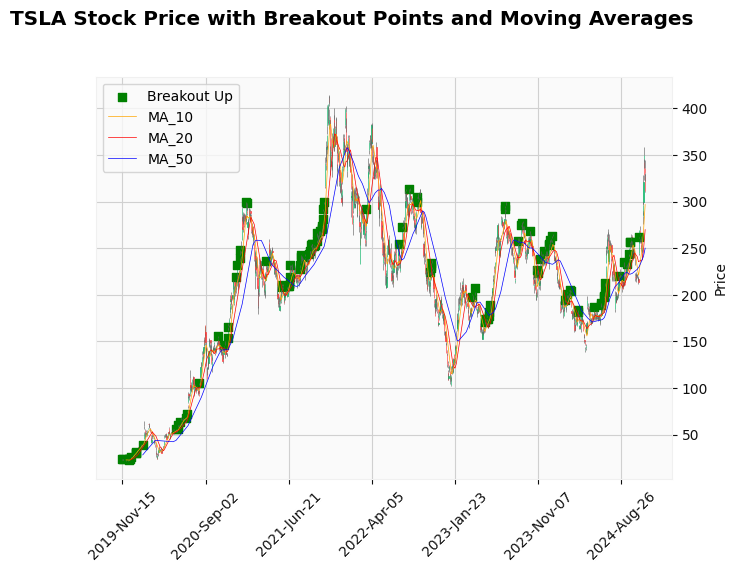

In [ ]:
# Display stock_data chart

import yfinance as yf
import pandas as pd
import mplfinance as mpf

# Assuming stock_data and breakout_label are already available
# Initialize empty aligned Series for breakout points
breakout_up = pd.Series(index=stock_data.index, dtype=float)
breakout_down = pd.Series(index=stock_data.index, dtype=float)

# Check if breakout_label contains the values before populating breakout points
if (stock_data['breakout_label'] == 1).any():
    breakout_up.loc[stock_data['breakout_label'] == 1] = stock_data.loc[stock_data['breakout_label'] == 1, 'High']
else:
    print("No breakout up points found.")

if (stock_data['breakout_label'] == -1).any():
    breakout_down.loc[stock_data['breakout_label'] == -1] = stock_data.loc[stock_data['breakout_label'] == -1, 'Low']
else:
    print("No breakout down points found.")

# Calculate Moving Averages
stock_data['MA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()

# Convert to OHLC format for mplfinance
ohlc_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Create breakout annotations and moving averages plots
apdict = []
if not breakout_up.isna().all():
    apdict.append(
        mpf.make_addplot(
            breakout_up,  # Aligned breakout up
            scatter=True,
            markersize=40,
            marker='s',
            color='green',
            label='Breakout Up'
        )
    )

if not breakout_down.isna().all():
    apdict.append(
        mpf.make_addplot(
            breakout_down,  # Aligned breakout down
            scatter=True,
            markersize=40,
            marker='s',
            color='red',
            label='Breakout Down'
        )
    )

# Add moving averages to the plot
apdict.append(
    mpf.make_addplot(
        stock_data['MA_10'],
        color='orange',
        width=0.5,
        label='MA_10'
    )
)
apdict.append(
    mpf.make_addplot(
        stock_data['MA_20'],
        color='red',
        width=0.5,
        label='MA_20'
    )
)
apdict.append(
    mpf.make_addplot(
        stock_data['MA_50'],
        color='blue',
        width=0.5,
        label='MA_50'
    )
)

# Plot the chart with mplfinance
mpf.plot(
    ohlc_data,
    type='candle',
    volume=False,
    style='yahoo',
    addplot=apdict,
    warn_too_much_data=100000,
    title=f'{ticker} Stock Price with Breakout Points and Moving Averages',
    ylabel='Price'
)


In [ ]:
# Combine with random forest forecast data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# --- Langkah 1: Siapkan Data ---

# Buat label target (1 untuk naik, 0 untuk tidak naik)
# Target adalah harga "Close" 90 hari ke depan dibandingkan harga saat ini
merged_fundamental_data['Close_90d'] = merged_fundamental_data['Close'].shift(-90)
merged_fundamental_data['point'] = (merged_fundamental_data['Close_90d'] > merged_fundamental_data['Close']).astype(int)

# Drop baris dengan nilai NaN (karena shift -90 menghasilkan NaN di baris akhir)
merged_fundamental_data.dropna(inplace=True)

# Pilih fitur dan target
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'pct_eps', 'pct_netIncome']
target = 'point'

X = merged_fundamental_data[features]
y = merged_fundamental_data[target]

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Langkah 2: Train Random Forest Model ---
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# --- Langkah 3: Evaluasi Model ---
# Prediksi data test
y_pred = model.predict(X_test)

# Tampilkan hasil evaluasi
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2f}")

# --- Langkah 4: Prediksi 90 Hari ke Depan ---
# Prediksi seluruh dataset (untuk menambahkan kolom prediksi ke data)
merged_fundamental_data['predicted_point'] = model.predict(X)

# Simpan data ke file
try:
    merged_fundamental_data.to_csv(f'{ticker}_random_forest_predictions.csv', index=True)
    merged_fundamental_data.to_excel(f'{ticker}_random_forest_predictions.xlsx')
    print(f"File prediksi telah disimpan sebagai {ticker}_random_forest_predictions.csv")
except Exception as e:
    print(f"Gagal menyimpan file prediksi: {e}")



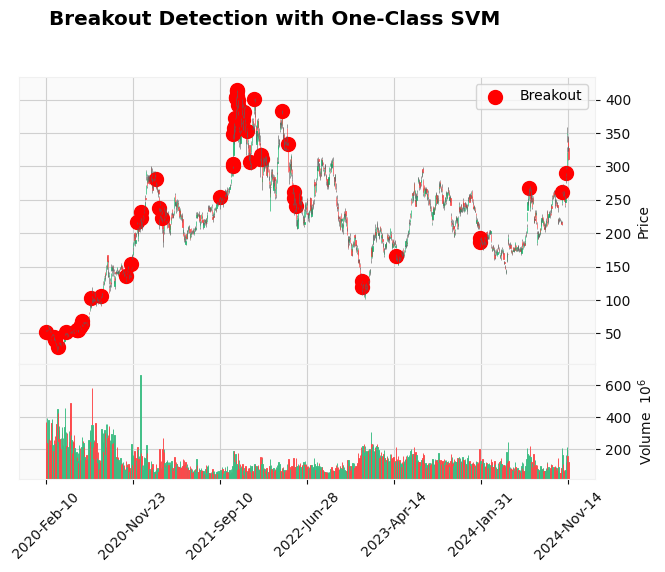

In [ ]:
# SVM First Prediction

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import mplfinance as mpf

# Example stock data (assumed downloaded and cleaned)
# Columns: 'Open', 'High', 'Low', 'Close', 'Volume'

# Feature Engineering
stock_data['ATR'] = (stock_data['High'] - stock_data['Low']).rolling(window=14).mean()
stock_data['BB_Width'] = 2 * stock_data['Close'].rolling(window=20).std()
stock_data['RSI'] = 100 - (100 / (1 + stock_data['Close'].diff().rolling(window=14).apply(
    lambda x: np.sum(x[x > 0]) / np.abs(np.sum(x[x < 0])), raw=True)))
stock_data['Volume_Change'] = stock_data['Volume'].pct_change()

# Drop NaNs from rolling calculations
features = stock_data[['ATR', 'BB_Width', 'RSI', 'Volume_Change']].dropna()

# Scale features for SVM
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)  # Adjust gamma and nu as needed
oc_svm.fit(scaled_features)

# Predict breakout candidates
features['Breakout_Score'] = oc_svm.decision_function(scaled_features)  # Higher score = more normal
features['Breakout_Flag'] = oc_svm.predict(scaled_features)  # 1 = normal, -1 = anomaly

# Merge results with original stock data
stock_data = stock_data.iloc[-len(features):].copy()  # Align indices
stock_data['Breakout_Flag'] = features['Breakout_Flag'].values

# Align breakout points
breakout_up_aligned = pd.Series(index=stock_data.index, dtype=float)
breakout_up_aligned[stock_data['Breakout_Flag'] == -1] = stock_data['High']  # Only breakout points

# Plot candlestick chart with breakout annotations
ohlc_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Define OHLC data

apdict = [
    mpf.make_addplot(breakout_up_aligned, scatter=True, markersize=100, marker='o', color='red', label='Breakout')
]

mpf.plot(
    ohlc_data,
    type='candle',
    volume=True,
    style='yahoo',
    addplot=apdict,
    warn_too_much_data=100000,
    title='Breakout Detection with One-Class SVM',
    ylabel='Price'
)


Accuracy: 0.89
Precision: 0.08
Recall: 0.03
F1-Score: 0.04


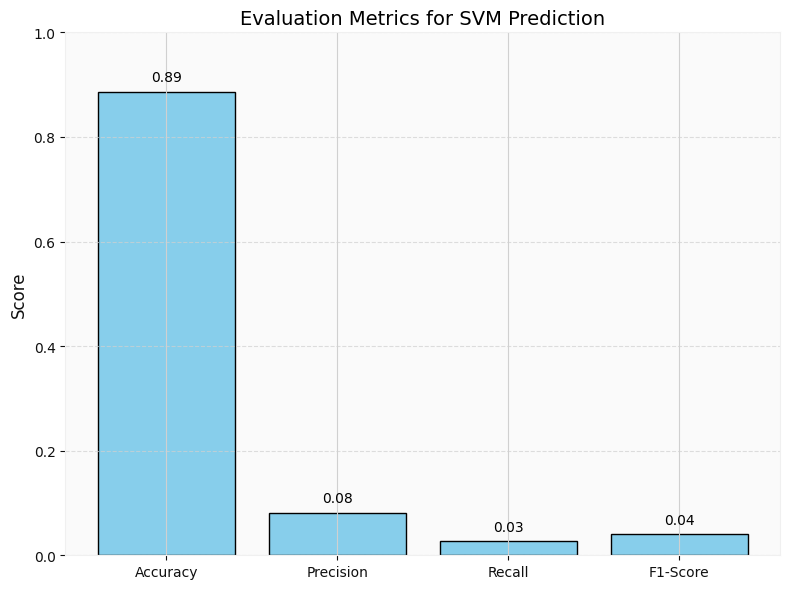

In [ ]:
# Evaluation

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract true labels and predictions
y_true = stock_data['breakout_label']
y_pred = stock_data['pred_up_breakout']  # Predicted flags from SVM

# Ensure alignment
assert len(y_true) == len(y_pred), "Mismatch in lengths of true and predicted labels."

# Map SVM predictions (-1 -> 0 for no-breakout, 1 -> 1 for breakout)
y_pred = y_pred.replace({-1: 0, 1: 1})  # Adjust based on breakout logic

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

import matplotlib.pyplot as plt

# Metrics for the evaluation
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue', edgecolor='black')
plt.title('Evaluation Metrics for SVM Prediction', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the metric value
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


# Data Retrieval

In [ ]:
# Retrieve Fundamental Data

import requests
import pandas as pd
# --- Data fundamental ---
# Set API key and symbol
api_key = ''  # Ganti dengan API key Anda
symbol = 'TSLA'  # Pastikan simbol saham sama

# Function to fetch data with error handling for rate limits
def fetch_alpha_vantage_data(url):
    response = requests.get(url)
    data = response.json()
    if 'Information' in data:
        print(f"Error fetching data: {data['Information']}")
        return None
    elif 'Note' in data:
        print(f"Error fetching data: {data['Note']}")
        return None
    else:
        return data

# Fetch EPS data
url_eps = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={symbol}&apikey={api_key}'
data_eps = fetch_alpha_vantage_data(url_eps)

# Check if data_eps is None due to rate limit
if data_eps and 'quarterlyEarnings' in data_eps:
    # Extract EPS data
    eps_data = [{'Date': item['fiscalDateEnding'], 'eps': item['reportedEPS']} for item in data_eps['quarterlyEarnings']]
    df_eps = pd.DataFrame(eps_data)
else:
    print("EPS data is not available due to API rate limit or other issues.")
    df_eps = pd.DataFrame()

# Fetch Net Income data
url_income_statement = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={api_key}'
data_income = fetch_alpha_vantage_data(url_income_statement)

# Check if data_income is None due to rate limit
if data_income and 'quarterlyReports' in data_income:
    # Extract Net Income data
    net_income_data = [{'Date': item['fiscalDateEnding'], 'netIncome': item['netIncome']} for item in data_income['quarterlyReports']]
    df_net_income = pd.DataFrame(net_income_data)
else:
    print("Net Income data is not available due to API rate limit or other issues.")
    df_net_income = pd.DataFrame()

# Merge EPS and Net Income data if both dataframes are not empty
if not df_eps.empty and not df_net_income.empty:
    df_fundamental = df_eps.merge(df_net_income, on='Date', how='inner')

    # Print columns to verify
    print("Fundamental Data Columns:", df_fundamental.columns)

    # Save combined data to a CSV file
    df_fundamental.to_csv(f'{symbol}_fundamental_data.csv', index=False)
else:
    print("Fundamental data is incomplete; cannot merge datasets.")

Fundamental Data Columns: Index(['Date', 'eps', 'netIncome'], dtype='object')


In [ ]:
# Preparing Data without minimizing outlier

import yfinance as yf
import pandas as pd
import requests

# --- Data teknikal ---
# Define the ticker of TSLA
ticker = 'TSLA'
start_date = '2018-11-15' # not the start date, this is to make sure technical calculation not null

# Define the timeframe
trim_date = '2019-11-15' # starting date
end_date = '2024-11-15' # last data would be 2024-11-14

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Message
print(" ")
print(f"Jumlah data dengan frekuensi harian saham {ticker} periode {trim_date} sampai {end_date}")

# Clean columns to remove the MultiIndex second level
stock_data.columns = stock_data.columns.get_level_values(0)

# --- Penambahan indikator teknikal ---

# ATR (Average True Range)
stock_data['ATR'] = (stock_data['High'] - stock_data['Low']).rolling(window=14).mean()

# Bollinger Bands Width (BB_Width)
stock_data['BB_Width'] = 2 * stock_data['Close'].rolling(window=20).std()

# RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data['RSI'] = compute_rsi(stock_data['Close'])

# MACD (Moving Average Convergence Divergence)
ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26

# --- Penambahan breakout_label ---
# Calculate highest and lowest closing prices in the last 10 trading days (2 weeks business days)
rolling_window = 10
stock_data[f'Highest_Close_{rolling_window}'] = (
    stock_data['Close'].shift(1).rolling(window=rolling_window).max()
)
stock_data[f'Lowest_Close_{rolling_window}'] = (
    stock_data['Close'].shift(1).rolling(window=rolling_window).min()
)

# Calculate consolidation condition
stock_data['Consolidation'] = (
    stock_data[f'Lowest_Close_{rolling_window}'] > 0.89 * stock_data[f'Highest_Close_{rolling_window}']
).astype(int)

# Determine breakout_label
def determine_breakout(row):
    if row['Consolidation'] == 1:
        if row['Close'] > row[f'Highest_Close_{rolling_window}']:
            # print(f"Breakout up detected at {row.name}: Close={row['Close']} > Highest_Close_{rolling_window}={row[f'Highest_Close_{rolling_window}']}")
            return 1  # Breakout di atas
        elif row['Close'] < row[f'Lowest_Close_{rolling_window}']:
            # print(f"Breakout down detected at {row.name}: Close={row['Close']} < Lowest_Close_{rolling_window}={row[f'Lowest_Close_{rolling_window}']}")
            return 0  # Breakout di bawah
    return 0  # Tidak ada breakout atau tidak dalam konsolidasi

stock_data['breakout_label'] = stock_data.apply(determine_breakout, axis=1)

print(f" ")
consolidation_count = stock_data['Consolidation'].sum()
print(f"Jumlah hari dalam konsolidasi: {consolidation_count}")
breakout_up_count = (stock_data['breakout_label'] == 1).sum()
print(f"Jumlah breakout ke atas: {breakout_up_count}")

# Drop intermediate columns if not needed
stock_data.drop(['Adj Close', f'Highest_Close_{rolling_window}', f'Lowest_Close_{rolling_window}', 'Consolidation'], axis=1, inplace=True)

# Trim data starting from '2019-11-15'
stock_data = stock_data[stock_data.index >= trim_date]

try:
  # save as csv
  stock_data.to_csv(f'{ticker}_technical_stock_data.csv')

  # check columns
  # print(stock_data.columns)

  # save as xlsx
  is_save_xlsx = True
  if (is_save_xlsx):
    # Pastikan indeks datetime bebas dari zona waktu
    if stock_data.index.tz is not None:
        stock_data.index = stock_data.index.tz_localize(None)
    # Pastikan kolom 'Date' bebas dari zona waktu
    if 'Date' in stock_data.columns:
        stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)
    stock_data.to_excel(f'{ticker}_technical_stock_data.xlsx')
except(Exception):
  print("GAGAL SAVE KARENA FILE MASIH TERBUKA")





[*********************100%***********************]  1 of 1 completed


 
Jumlah data dengan frekuensi harian saham TSLA periode 2019-11-15 sampai 2024-11-15
 
Jumlah hari dalam konsolidasi: 687
Jumlah breakout ke atas: 149
